In [1]:
## Import Python libraries ## 

import numpy as np
import xsimlab as xs
import matplotlib.pyplot as plt
import xarray as xr


%matplotlib inline
%reload_ext xsimlab.ipython


import fastscape

from orographic_precipitation.fastscape_ext import precip_model
from fastscape.processes import Bedrock


In [2]:
print('xarray-simlab version: ', xs.__version__)
print('fastscape version: ', fastscape.__version__)

xarray-simlab version:  0.5.0
fastscape version:  0.1.0


In [3]:
## Build xarray-simlab model ##
MonteFitzroyLEM = precip_model
MonteFitzroyLEM = precip_model.drop_processes(['init_topography'])
MonteFitzroyLEM = MonteFitzroyLEM.update_processes({'bedrock': Bedrock})

MonteFitzroyLEM

<xsimlab.Model (17 processes, 26 inputs)>
grid
    shape                  [in] ('shape_yx',) nb. of grid nodes in ...
    length                 [in] ('shape_yx',) total grid length in ...
boundary
    status                 [in] () or ('border',) node status at bo...
fs_context
uplift
    rate                   [in] () or ('y', 'x') uplift rate
tectonics
surf2erode
init_erosion
diffusion
    diffusivity            [in] () or ('y', 'x') diffusivity (trans...
flow
orographic
    lapse_rate             [in] environmental lapse rate
    lapse_rate_m           [in] moist adiabatic lapse rate
    ref_density            [in] reference saturation water vapor de...
    latitude               [in] latitude
    precip_base            [in] () or ('y', 'x') background, non-or...
    rainfall_frequency  [inout] daily rainfall frequency
    wind_speed             [in] wind speed
    wind_dir               [in] wind direction (azimuth)
    conv_time              [in] conversion time
    fall_time    

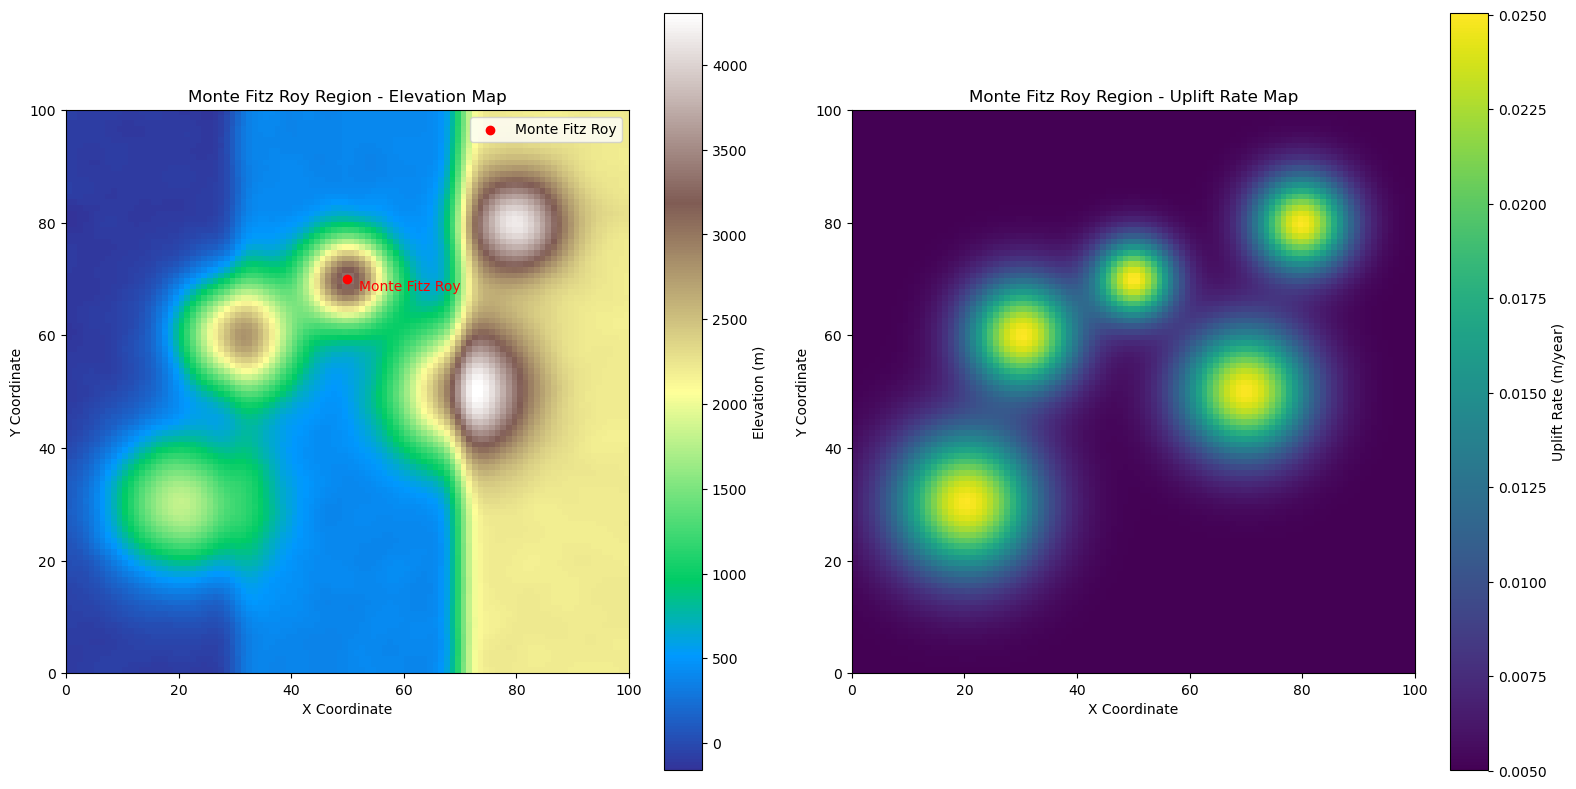

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Grid parameters
nx, ny = 100, 100  # Higher resolution for detailed features
nn = nx * ny
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)

# Initialize elevation map
InitialTopography = np.zeros((nx, ny))

# Parameters for Monte Fitz Roy
fitzroy_x, fitzroy_y = 0.5, 0.7  # Center of Monte Fitz Roy
fitzroy_height = 3400            # Peak elevation (m)
fitzroy_width = 0.05             # Width of Monte Fitz Roy

# Add Monte Fitz Roy
InitialTopography += (
    fitzroy_height * np.exp(-((X - fitzroy_x)**2 + (Y - fitzroy_y)**2) / (2 * fitzroy_width**2))
)

# Parameters for surrounding mountains
peak_params = [
    {"x": 0.3, "y": 0.6, "height": 2800, "width": 0.07},  # Mountain 1
    {"x": 0.7, "y": 0.5, "height": 2600, "width": 0.08},  # Mountain 2
    {"x": 0.2, "y": 0.3, "height": 2000, "width": 0.09},  # Mountain 3
    {"x": 0.8, "y": 0.8, "height": 2200, "width": 0.06},  # Mountain 4
]

# Add surrounding mountains
for peak in peak_params:
    InitialTopography += (
        peak["height"]
        * np.exp(-((X - peak["x"])**2 + (Y - peak["y"])**2) / (2 * peak["width"]**2))
    )

# Add a plateau to the east (right side of the grid)
plateau_x_start, plateau_x_end = 0.7, 1.0  # Plateau spans x from 0.7 to 1.0
plateau_height = 1800
plateau_mask = (X >= plateau_x_start) & (X <= plateau_x_end)
InitialTopography[plateau_mask] += plateau_height

# Add a foreland basin to the west (left side of the grid)
basin_x_start, basin_x_end = 0.0, 0.3  # Basin spans x from 0.0 to 0.3
basin_depth = -500  # Foreland basin is lower than the valley
basin_mask = (X >= basin_x_start) & (X <= basin_x_end)
InitialTopography[basin_mask] += basin_depth

# Add valleys (baseline elevation)
valley_height = 400
InitialTopography += valley_height

# Add random noise for realism
np.random.seed(42)
WhiteNoiseLevel = 100  # Standard deviation of noise
Noise = np.random.normal(0, WhiteNoiseLevel, (nx, ny))
InitialTopography += Noise

# Smooth the noise for more natural features
InitialTopography = gaussian_filter(InitialTopography, sigma=2)

# Uplift rates: Higher near peaks, lower in valleys, plateaus, and basin
UpliftRates = np.zeros((nx, ny))
for peak in peak_params + [{"x": fitzroy_x, "y": fitzroy_y, "height": fitzroy_height, "width": fitzroy_width}]:
    UpliftRates += 0.02 * np.exp(-((X - peak["x"])**2 + (Y - peak["y"])**2) / (2 * peak["width"]**2))
UpliftRates += 0.005  # Baseline uplift rate

# Plotting the results
plt.figure(figsize=(16, 8))

# Elevation map
plt.subplot(1, 2, 1)
plt.imshow(InitialTopography, cmap='terrain', origin='lower', extent=[0, nx, 0, ny])
plt.colorbar(label='Elevation (m)')
plt.title('Monte Fitz Roy Region - Elevation Map')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Annotate Monte Fitz Roy
plt.scatter(fitzroy_x * nx, fitzroy_y * ny, color='red', label='Monte Fitz Roy', zorder=10)
plt.text(fitzroy_x * nx + 2, fitzroy_y * ny - 2, 'Monte Fitz Roy', color='red', fontsize=10)

# Add legend
plt.legend()

# Uplift rate map
plt.subplot(1, 2, 2)
plt.imshow(UpliftRates, cmap='viridis', origin='lower', extent=[0, nx, 0, ny])
plt.colorbar(label='Uplift Rate (m/year)')
plt.title('Monte Fitz Roy Region - Uplift Rate Map')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.tight_layout()
plt.show()


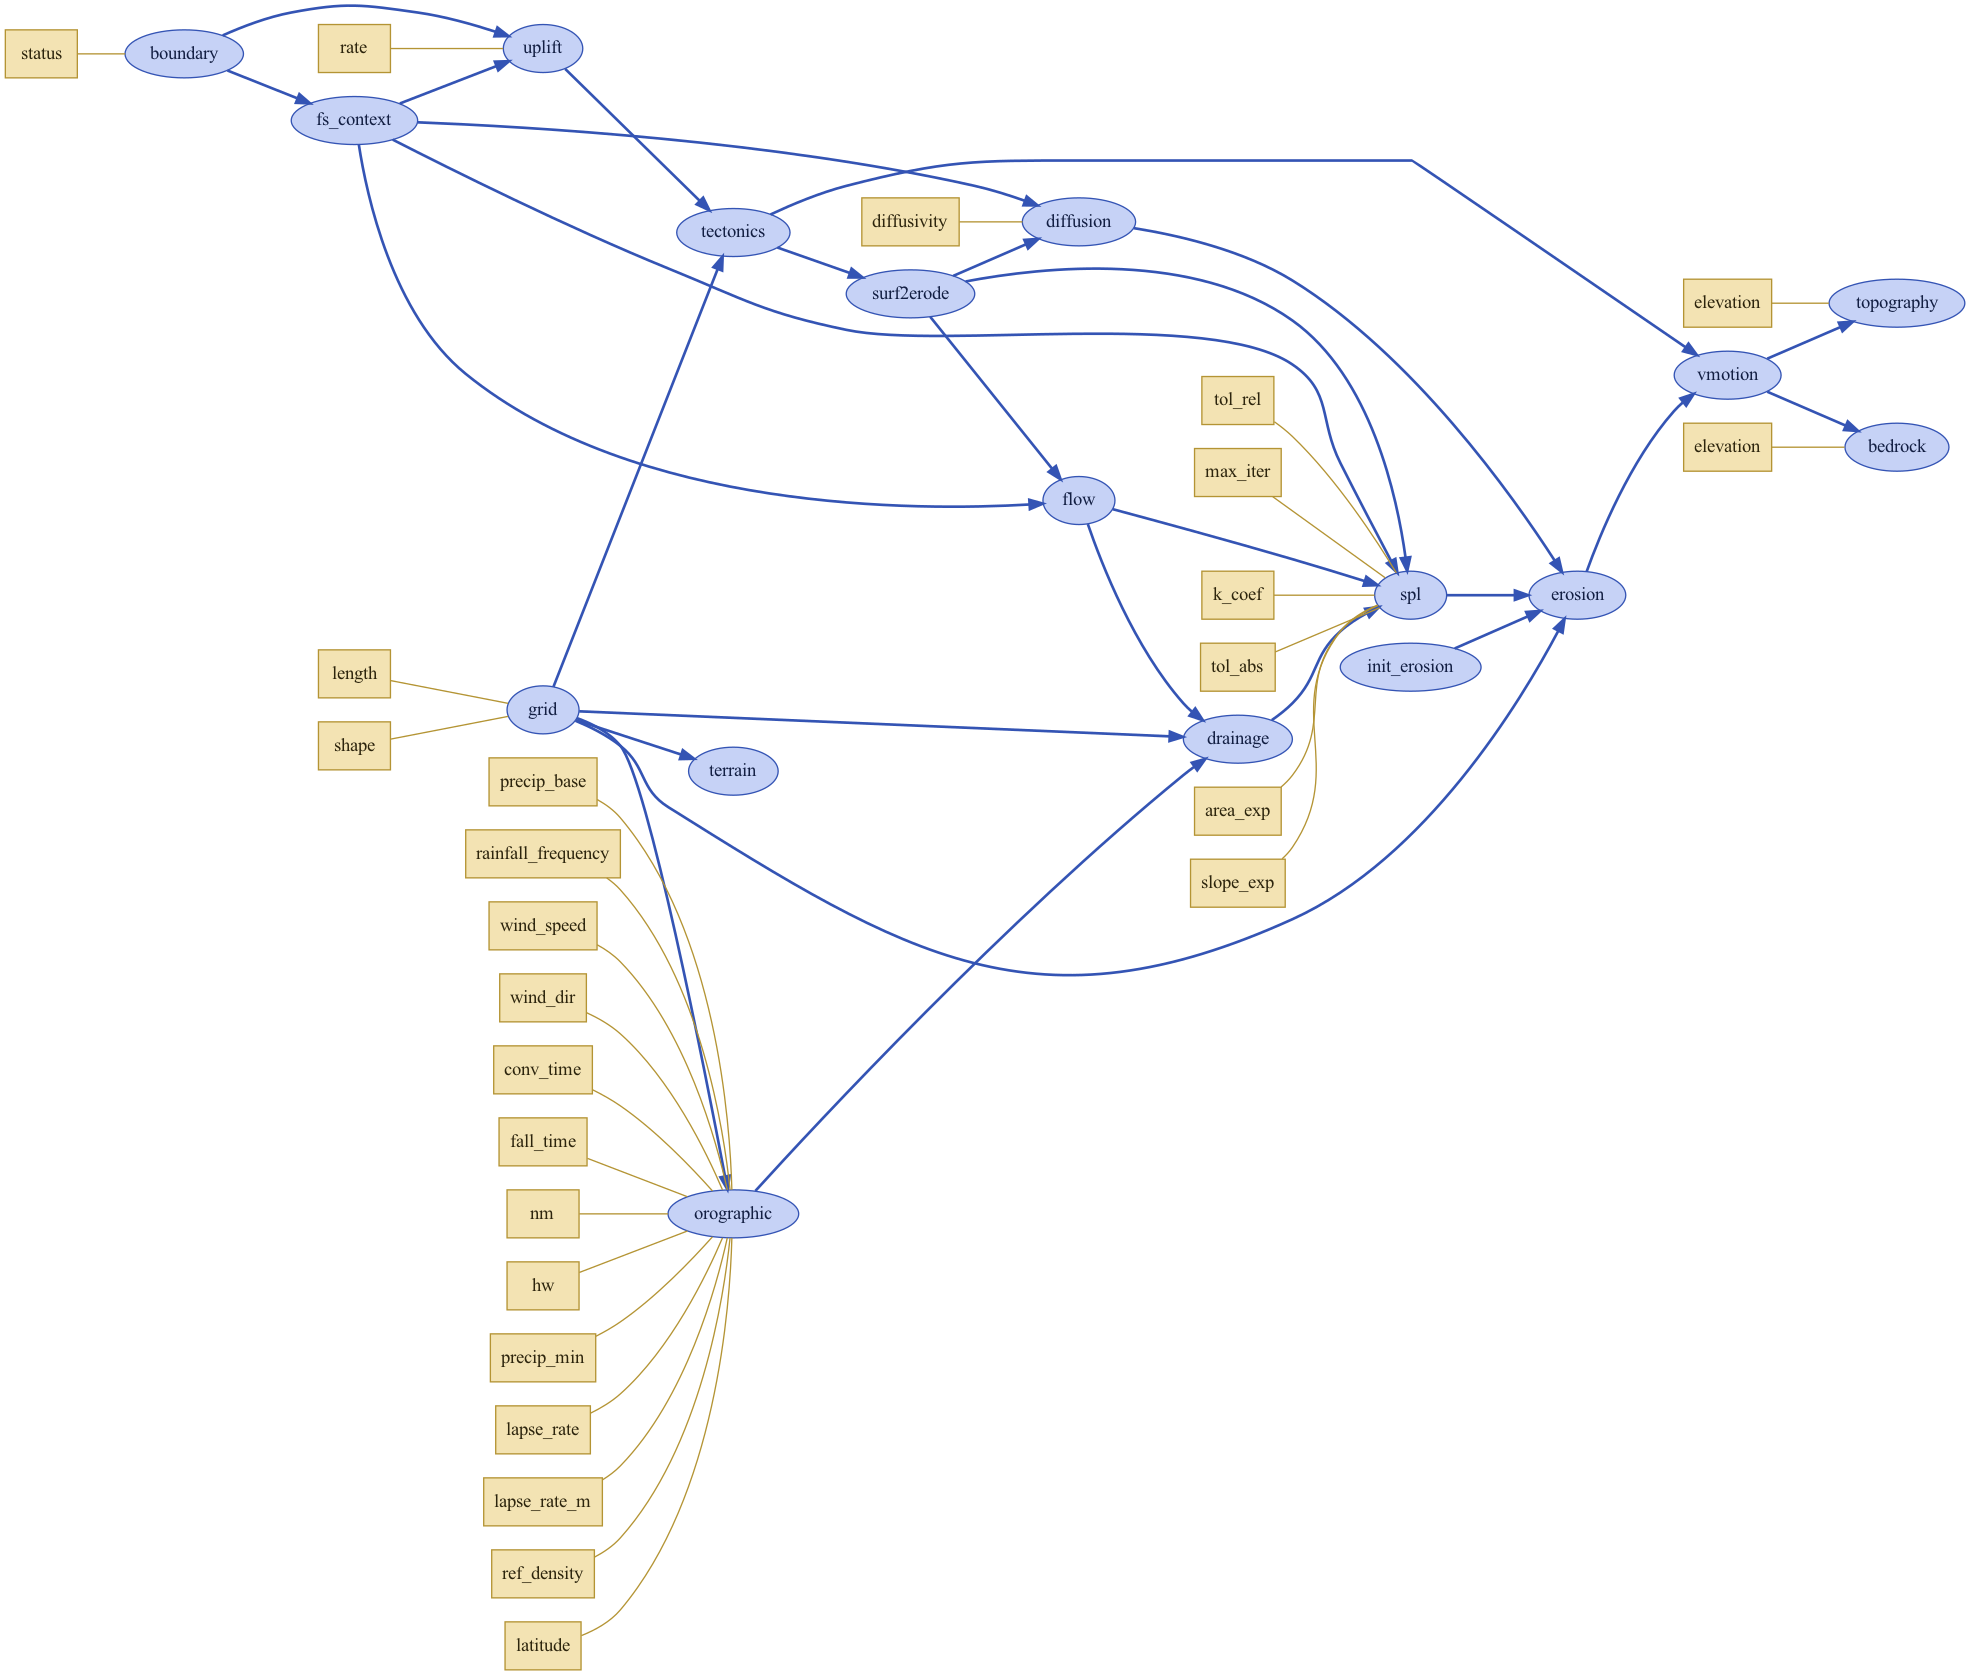

In [5]:
## Visualise xarray-simlab ##
MonteFitzroyLEM.visualize(show_inputs='True')

In [6]:
## Model dimensions/grid dimensions ##
nx = 400
ny = 400
nn = nx * ny

xl = 400.e3
yl = 400.e3 

BoundaryCondition = ['looped', 'looped', 'fixed_value', 'fixed_value']

## Model time and time stepping ##
EndTime_1 = 5e6
EndTime_2 = 5e6
EndTime_3 = 8e6
TimeSteps_1 = 10001
TimeSteps_2 = 10001
TimeSteps_3 = 16001

# EndTime = 1e6
# TimeSteps = 1001
ModelTime_1 = np.linspace(0., EndTime_1, TimeSteps_1)
ModelTime_2 = np.linspace(0., EndTime_2, TimeSteps_2)
ModelTime_3 = np.linspace(0., EndTime_3, TimeSteps_3)

PlotStep = 100

## Tectonics ##
k_coef= 2.5e-5
area_exp = 0.4
slope_exp = 1.0
diffusion_diffusivity = 0.

## Background Precipitation ##
precip_base_arr = np.ones([400, 400])
precip_base_arr=precip_base_arr*5
xr_2d = xr.DataArray(np.ones((400,400)), dims=['y','x'])
precip_base_xr=xr_2d*5

## Orographic ##
lapse_rate = -5.4 #mean lapse rate of area not too far away 
lapse_rate_m = -6.5 #left at default
ref_density = 7.4e-3  #left default
rainfall_frequency = 295 #calculated based on weather days plot from website
latitude = 46  #latitude around the area of monte fitzroy in the Patagonian Andes
precip_base =  precip_base_xr #not sure if I should change this or not
wind_speed = 10 #base to start with 
wind_dir = 270  # estimated direction given weather info 
precip_min = 0.1 #chatgpt value so could be wrong
conv_time = 2000 #2000 thesis value
fall_time = 2000 #2000 thesis value
nm = 0.003  #0.03 #thesis value
hw = 12800  #Calculated by chatgpt so could be wrong


## Initial topography ##
WhiteNoiseLevel = 50 # in [m], amplitude of noise

## Seed for Reproducibility ##
RandomSeed = 1410

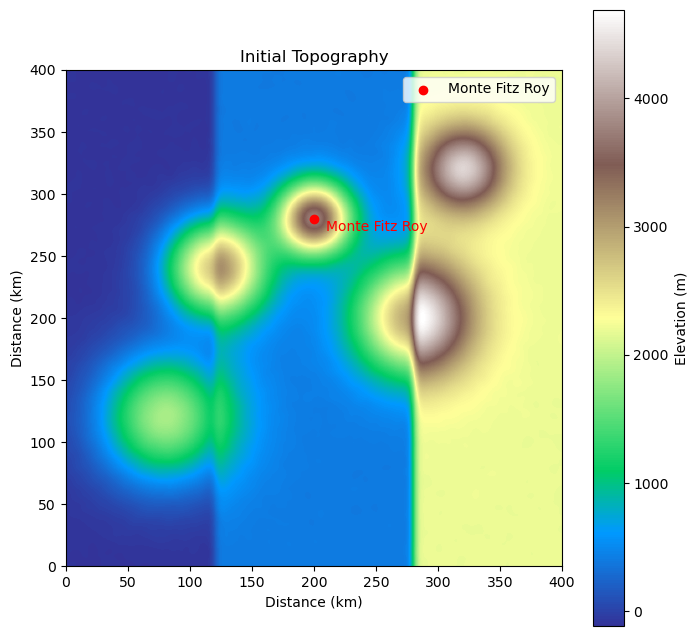

In [7]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

## Model dimensions/grid dimensions ##
nx = 400
ny = 400
nn = nx * ny

xl = 400.e3
yl = 400.e3 

BoundaryCondition = ['looped', 'looped', 'fixed_value', 'fixed_value']

## Model time and time stepping ##
EndTime_1 = 5e6
EndTime_2 = 5e6
EndTime_3 = 8e6
TimeSteps_1 = 10001
TimeSteps_2 = 10001
TimeSteps_3 = 16001

ModelTime_1 = np.linspace(0., EndTime_1, TimeSteps_1)
ModelTime_2 = np.linspace(0., EndTime_2, TimeSteps_2)
ModelTime_3 = np.linspace(0., EndTime_3, TimeSteps_3)

PlotStep = 100

## Tectonics ##
k_coef = 2.5e-5
area_exp = 0.4
slope_exp = 1.0
diffusion_diffusivity = 0.

## Background Precipitation ##
precip_base_arr = np.ones([20, 20])
precip_base_arr = precip_base_arr * 5
xr_2d = xr.DataArray(np.ones((20, 20)), dims=['y', 'x'])
precip_base_xr = xr_2d * 5

## Orographic ##
lapse_rate = -5.4  # mean lapse rate of area not too far away
lapse_rate_m = -6.5  # left at default
ref_density = 7.4e-3  # left default
rainfall_frequency = 295  # calculated based on weather days plot from website
latitude = 46  # latitude around the area of Monte Fitz Roy in the Patagonian Andes
precip_base = precip_base_xr  # not sure if I should change this or not
wind_speed = 10  # base to start with
wind_dir = 270  # estimated direction given weather info
precip_min = 0.1  # chatgpt value so could be wrong
conv_time = 2000  # thesis value
fall_time = 2000  # thesis value
nm = 0.003  # thesis value
hw = 12800  # Calculated by chatgpt so could be wrong

## Initial topography ##
WhiteNoiseLevel = 50  # in [m], amplitude of noise
RandomSeed = 1410
np.random.seed(RandomSeed)

# Initialize topography
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)

# Monte Fitz Roy parameters
fitzroy_x, fitzroy_y = 0.5, 0.7
fitzroy_height = 3400
fitzroy_width = 0.05

# Add Monte Fitz Roy
InitialTopography = fitzroy_height * np.exp(-((X - fitzroy_x)**2 + (Y - fitzroy_y)**2) / (2 * fitzroy_width**2))

# Surrounding mountain parameters
peak_params = [
    {"x": 0.3, "y": 0.6, "height": 2800, "width": 0.07},
    {"x": 0.7, "y": 0.5, "height": 2600, "width": 0.08},
    {"x": 0.2, "y": 0.3, "height": 2000, "width": 0.09},
    {"x": 0.8, "y": 0.8, "height": 2200, "width": 0.06},
]

for peak in peak_params:
    InitialTopography += peak["height"] * np.exp(-((X - peak["x"])**2 + (Y - peak["y"])**2) / (2 * peak["width"]**2))

# Add a plateau to the east
plateau_x_start, plateau_x_end = 0.7, 1.0
plateau_height = 1800
plateau_mask = (X >= plateau_x_start) & (X <= plateau_x_end)
InitialTopography[plateau_mask] += plateau_height

# Add a foreland basin to the west
basin_x_start, basin_x_end = 0.0, 0.3
basin_depth = -500
basin_mask = (X >= basin_x_start) & (X <= basin_x_end)
InitialTopography[basin_mask] += basin_depth

# Add valleys (baseline elevation)
valley_height = 400
InitialTopography += valley_height

# Add random noise for realism
Noise = np.random.normal(0, WhiteNoiseLevel, (nx, ny))
InitialTopography += Noise

# Smooth the topography for natural features
InitialTopography = gaussian_filter(InitialTopography, sigma=3)

# Plotting the initial topography
plt.figure(figsize=(8, 8))
plt.imshow(InitialTopography, cmap='terrain', origin='lower', extent=[0, xl / 1e3, 0, yl / 1e3])
plt.colorbar(label='Elevation (m)')
plt.scatter(fitzroy_x * xl / 1e3, fitzroy_y * yl / 1e3, color='red', label='Monte Fitz Roy')
plt.text(fitzroy_x * xl / 1e3 + 10, fitzroy_y * yl / 1e3 - 10, 'Monte Fitz Roy', color='red')
plt.title('Initial Topography')
plt.xlabel('Distance (km)')
plt.ylabel('Distance (km)')
plt.legend()
plt.show()


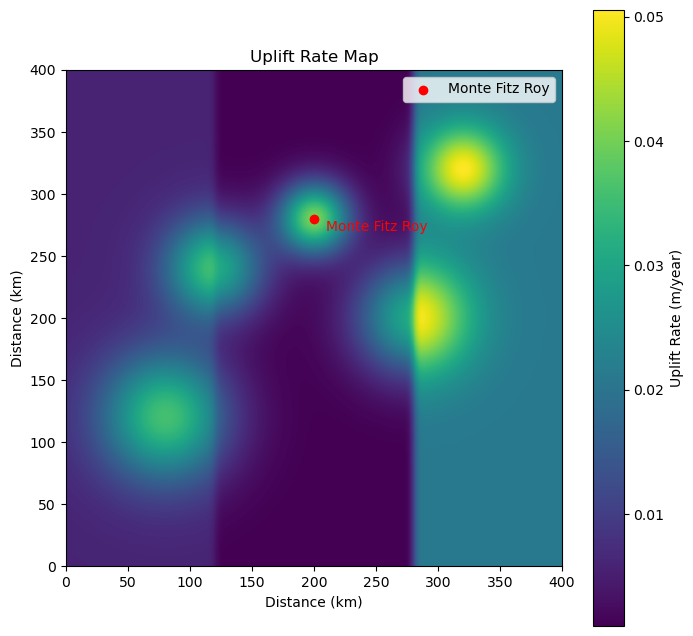

In [8]:
# Define uplift rates based on regions
UpliftRates = np.zeros((nx, ny))

# High uplift rates in mountainous regions
for peak in peak_params:
    UpliftRates += 0.03 * np.exp(-((X - peak["x"])**2 + (Y - peak["y"])**2) / (2 * peak["width"]**2))

# Uplift rate for Monte Fitz Roy
UpliftRates += 0.04 * np.exp(-((X - fitzroy_x)**2 + (Y - fitzroy_y)**2) / (2 * fitzroy_width**2))

# Medium uplift rates on the plateau
plateau_uplift_rate = 0.02
UpliftRates[plateau_mask] += plateau_uplift_rate

# Low uplift rates in the basin
basin_uplift_rate = 0.005
UpliftRates[basin_mask] += basin_uplift_rate

# Add a baseline uplift rate to the entire region
UpliftRates += 0.001  # A small uplift rate across all regions

# Smooth uplift rates for natural transitions
UpliftRates = gaussian_filter(UpliftRates, sigma=3)

# Plotting the uplift rate map
plt.figure(figsize=(8, 8))
plt.imshow(UpliftRates, cmap='viridis', origin='lower', extent=[0, xl / 1e3, 0, yl / 1e3])
plt.colorbar(label='Uplift Rate (m/year)')
plt.scatter(fitzroy_x * xl / 1e3, fitzroy_y * yl / 1e3, color='red', label='Monte Fitz Roy')
plt.text(fitzroy_x * xl / 1e3 + 10, fitzroy_y * yl / 1e3 - 10, 'Monte Fitz Roy', color='red')
plt.title('Uplift Rate Map')
plt.xlabel('Distance (km)')
plt.ylabel('Distance (km)')
plt.legend()
plt.show()


In [10]:
# Reshape precip_base_xr to match the model grid (400x400)
precip_base_large = precip_base_xr.interp(
    x=np.linspace(0, nx - 1, nx), 
    y=np.linspace(0, ny - 1, ny), 
    method='linear'
)

# Set up input parameters for xarray-simlab model
in_ds_S1 = xs.create_setup(
    model=MonteFitzroyLEM,
    clocks={
        'time': ModelTime_1,
        'output': ModelTime_1[::PlotStep]
    },
    master_clock='time',
    input_vars={
        'grid': {
            'shape': [nx, ny],
            'length': [xl, yl],
        },
        'boundary': {
            'status': BoundaryCondition
        },
        'topography': {
            # Use the corrected 2D initial topography
            'elevation': InitialTopography,
        },
        'bedrock': {
            # Use the same corrected 2D initial topography
            'elevation': InitialTopography,
        },
        'uplift': {
            # Ensure uplift rates match the grid
            'rate': UpliftRates,
        },
        'spl': {
            'k_coef': k_coef,
            'area_exp': area_exp,
            'slope_exp': slope_exp,
        },
        'diffusion': {
            'diffusivity': diffusion_diffusivity,
        },
        'orographic': {
            'lapse_rate': lapse_rate,
            'lapse_rate_m': lapse_rate_m,
            'ref_density': ref_density,
            'rainfall_frequency': rainfall_frequency,
            'latitude': latitude,
            'precip_base': precip_base_large,  # Use the resized precipitation base
            'wind_speed': wind_speed,
            'wind_dir': wind_dir,
            'precip_min': precip_min,
            'conv_time': conv_time,
            'fall_time': fall_time,
            'nm': nm,
            'hw': hw,
        },
    },
    output_vars={
        'topography__elevation': 'time',
        'orographic__precip_rate': 'time'
    }
)

# Check the setup
print(in_ds_S1)




<xarray.Dataset>
Dimensions:                         (time: 10001, output: 101, shape_yx: 2,
                                     border: 4, y: 400, x: 400)
Coordinates:
  * time                            (time) float64 0.0 500.0 ... 5e+06 5e+06
  * output                          (output) float64 0.0 5e+04 ... 5e+06
Dimensions without coordinates: shape_yx, border, y, x
Data variables: (12/26)
    spl__tol_rel                    float64 0.0001
    spl__tol_abs                    float64 0.0001
    spl__max_iter                   int64 100
    grid__shape                     (shape_yx) int64 400 400
    grid__length                    (shape_yx) float64 4e+05 4e+05
    boundary__status                (border) <U11 'looped' ... 'fixed_value'
    ...                              ...
    orographic__wind_dir            int64 270
    orographic__precip_min          float64 0.1
    orographic__conv_time           int64 2000
    orographic__fall_time           int64 2000
    orographic__nm 

In [11]:
with xs.monitoring.ProgressBar():
    out_ds_S1 = in_ds_S1.xsimlab.run(model=MonteFitzroyLEM)
    
out_ds_S1

             0% | initialize 

In [ ]:
out_ds_S1.topography__elevation.isel(time=[0,1,10,100]).plot(col='time',figsize=(20, 4))
plt.show()